# Hands-on Tutorial for Link Analysis

Welcome to hands-on tutorial for link analysis. 
In this tutorial, we will study several techniques for link analysis in graphs. 
This tutorial consists of four sessions, and each session will handle the following topic:

* **Session 1**. Tutorial on PageRank - Part 1 (50 mins)
* **Session 2**. Tutorial on PageRank - Part 2 (50 mins)
* **Session 3**. Tutorial on Topic-specific PageRank (50 mins)
* **Session 4**. Tutorial on HITS (50 mins) <<<

We recommend fully understanding link analysis (or ranking) models such as PageRank, Topic-specific PageRank, and HITS before entering this tutorial since we will **NOT** explain the theoretical backgrounds on these techniques during the tutorial. 
We will mainly focus on how to implement the algorithms of those models and how to rank nodes in real-world graphs using those ranking models. 

The main contributor of this meterial is as follows:

* Jinhong Jung (jinhongjung@snu.ac.kr)

------

## Session 4. Tutorial on HITS (50 mins)
In this session, we will explore how to implement HITS in Python. 
The main goals of this session are summarized as follows:
* **Goal 1.** How to implement HITS based on sparse matrices using `numpy` and `scipy` in Python
* **Goal 2.** To perform a qualitative analysis of the ranking result from HITS in real-world networks

The outline of this session is as follows:
* **Step 1.** Review HITS algorithm
* **Step 2.** Implement HITS algorithm - the sparse matrix version
* **Step 3.** Validate your HITS implementation
* **Step 4.** Qualitative analysis of the ranking result from HITS
* **Step 5.** Comparison between PageRank and HITS
------

### Step 1. Review HITS algorithm

In this step, we will briefly review HITS algorithm which is another global node ranking model in graphs. 

#### Step 1-1. Mathematical definition of HITS
Given an adjacency matrix of a graph, HITS computes the hub and authority score vectors which can be used for ranking nodes in the graph. 

##### Problem definition of HITS
* **Input**: adjacency matrix $\mathbf{A}\in \mathbb{R}^{n \times n}$ of a graph $G=(V, E)$
* **Output**: hub score vector $\mathbf{h} \in \mathbb{R}^{n}$, and authority score vector $\mathbf{a} \in \mathbb{R}^{n}$ such that

$$
\mathbf{h} = \mathbf{A}\mathbf{a} \text{ and } \\
\mathbf{a} = \mathbf{A}^{\top}\mathbf{h}
$$

* The above equations are called the equations for HITS.

Note that HITS does not require the row-normalized adjacency matrix. 

#### Step 1-2. Iterative Algorithm for HITS
The hub and authority score vectors, $\mathbf{h}$ and $\mathbf{a}$, are obtained by iteratively computing the equations for HITS.   
Note that for each iteration, we need to L2-normalize the vectors $\mathbf{h}$ and $\mathbf{a}$.
The following pseudo-code represents the iterative algorithm for HITS. 

<img src="./images/iterative-algorithm-hits.png" width="400">

We will implement the iterative algorithm in Python. 

------

### Step 2. Implement HITS algorithm - the sparse matrix version
We are going to implement the sparse matrix version of HITS algorithm in Python.

#### Step 2-1. Set up requirements for this tutorial

As in the previous sessions, we first import required packages as follows:

In [1]:
try:
    import numpy
except ImportError:
    print("numpy is not installed, type pip install numpy")

try:
    import scipy
except ImportError:
    print("scipy is not installed, type pip install scipy")
    
try:
    import matplotlib
except ImportError:
    print("matplotlib is not installed, type pip install matplotlib")
    
try:
    import pandas
except ImportError:
    print("pandas is not installed, type pip install pandas")

#### Step 2-2. Implement the phase for loading the graph dataset
In this step, we will implement the phase for loading the graph dataset of the sparse matrix version of HITS. 
We first need to import the following packages for this. 

In [2]:
# the below commands restrict the number of computation threads to 1
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np
from scipy.sparse import csr_matrix, find
import pandas as pd

As in the previous sessions, we implement the following function for load graph datasets.
Note that we do not need to modify the function since the functionality in the version is the same with that of Session 3. 

In [3]:
class SparseHITS:
    def load_graph_dataset(self, data_home, is_undirected=False):
        '''
        Load the graph dataset from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset (edges.tsv, node_labels.tsv)
            is_undirected: bool
                if the graph is undirected
        '''
        # Step 1. self file paths from data_home
        edge_path = "{}/edges.tsv".format(data_home)
        
        # Step 2. read the list of edges from edge_path
        edges = np.loadtxt(edge_path, dtype=int)
        n = int(np.amax(edges[:, 0:2])) + 1
        
        # Step 3. convert the edge list to the weighted adjacency matrix
        rows = edges[:, 0]
        cols = edges[:, 1]
        weights = edges[:, 2]
        self.A = csr_matrix((weights, (rows, cols)), shape=(n, n), dtype=float)
        if is_undirected == True:
            self.A = self.A + self.A.T
        self.AT = self.A.T
                
        # Step 4. set n (# of nodes) and m (# of edges)
        self.n = self.A.shape[0]     # number of nodes
        self.m = self.A.nnz          # number of edges

In [4]:
class SparseHITS(SparseHITS):
    def load_node_labels(self, data_home):
        '''
        Load the node labels from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset
        '''
        label_path = "{}/node_labels.tsv".format(data_home)
        self.node_labels = pd.read_csv(label_path, sep="\t")        

Let's check if the function is correctly implemented. 
We will use the small dataset at `./data/small` as before.

In [5]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
print("The number n of nodes: {}".format(hits.n))
print("The number m of edges: {}".format(hits.m))

The number n of nodes: 29
The number m of edges: 376


#### Step 2-3. Implement the iterative phase

Contrary to PageRank, HITS does not need a normalization phase for the adjacency matrix. 
In this step, we implement the iterative phase of HITS in the following algorithm.

<img src="./images/iterative-algorithm-hits.png" width="400">


In [6]:
class SparseHITS(SparseHITS):
    def iterate_HITS(self, epsilon=1e-9, maxIters=100):
        '''
        Iterate the HITS equation to obatin the hub & authority score vectors
        
        inputs:
            epsilon: float
                the error tolerance of the iteration
            maxIters: int
                the maximum number of iterations
                
        outputs:
            h: np.ndarray (n x 1 vector)
                the final hub score vector
            a: np.ndarray (n x 1 vector)
                the final authority score vector
            h_residuals: list
                the list of hub residuals over the iteration
            a_residuals: list
                the list of authority residuals over the iteration

        '''
        old_h = np.ones(self.n)/self.n
        old_a = np.ones(self.n)/self.n
        h_residuals = []
        a_residuals = []
        
        for t in range(maxIters):
            h = self.A.dot(old_a)
            a = self.AT.dot(h)
                        
            h = h / np.linalg.norm(h, 2)
            a = a / np.linalg.norm(a, 2)
            
            h_residual = np.linalg.norm(h - old_h, 1)
            a_residual = np.linalg.norm(a - old_a, 1)
            h_residuals.append(h_residual)
            a_residuals.append(a_residual)
            old_h = h
            old_a = a
            
            if h_residual < epsilon and a_residual < epsilon:
                break
        
        return h, a, h_residuals, a_residuals

Let's check the implementation is correctly performed. 
We will briefly check each personalized ranking result using `pandas`. 
See the following code where a seed node is given. 
Note that the given seed node should have a high ranking score. 

In [7]:
import pandas as pd

def rank_nodes(ranking_scores, topk=-1):
    sorted_nodes = np.flipud(np.argsort(ranking_scores))
    sorted_scores = ranking_scores[sorted_nodes]
    ranking_results = pd.DataFrame()
    ranking_results["node_id"] = sorted_nodes
    ranking_results["score"] = sorted_scores
    
    return ranking_results[0:topk]

In [8]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h, a, _, _ = hits.iterate_HITS(epsilon=1e-9, maxIters=100)

print("Top-5 rankings based on the hub score vector:")
display(rank_nodes(h, 5))

print("Top-5 rankings based on the authority score vector")
display(rank_nodes(a, 5))

Top-5 rankings based on the hub score vector:


,node_id,score
0,4,0.320863
1,5,0.317454
2,3,0.293383
3,2,0.224871
4,21,0.219779


Top-5 rankings based on the authority score vector


,node_id,score
0,7,0.269209
1,8,0.262543
2,10,0.260004
3,13,0.249306
4,11,0.242907


### Step 3. Validate your HITS implementation

We will validate the implementation of HITS. 
Similarly to PageRank, we will check if the residuals of the iterative algorithm monotonically decrease, and compare between the exact and iterative solutions of HITS. 

#### Step 3-1. Check if the residuals of the iterative algorithm monotonically decrease

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13}) # set the font-size in the figure

def plot_residuals(residuals, title):
    plt.semilogy(residuals, marker='o', markersize=5)
    plt.title(title)
    plt.ylim(bottom=1e-10, top=1e1)
    plt.ylabel('Residual')
    plt.xlabel('# of iterations')
    plt.grid(True)
    plt.show()

Let's check the plot for the hub residuals first. 

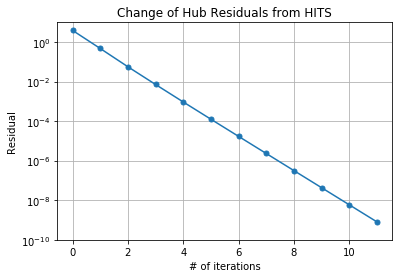

In [10]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h, a, h_residuals, a_residuals = hits.iterate_HITS(epsilon=1e-9, maxIters=100)

plot_residuals(h_residuals, 'Change of Hub Residuals from HITS')

Next, the following will plot the authority residuals. 

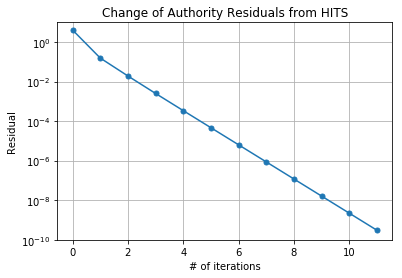

In [11]:
plot_residuals(a_residuals, 'Change of Authority Residuals from HITS')

As you can see, those residuals monotonically decrease as the number of iteration increases. 

#### Step 3-2. Check if the iterative solution is equal to the exact solution of HITS

We can directly compute the hub ans authority score vectors of HITS as follows:
* The hub score vector $\mathbf{h}$ is the principle eigenvector of $\mathbf{A}\mathbf{A}^{\top}$.
* The authority score vector $\mathbf{a}$ is the principle eigenvector of $\mathbf{A}^{\top}\mathbf{A}$.

The principle eigenvector of a matrix is an eigenvector of the largest eigenvalue. 
Suppose the Singular Value Decomposition (SVD) of the adjacency matrix is $\mathbf{A}=\mathbf{U}\mathbf{S}\mathbf{V}^{\top}$. Then,
* $\mathbf{h}$ is the first (most left) vector of $\mathbf{U}$. 
* $\mathbf{a}$ is the first (most left) vector of $\mathbf{V}$.

We will not describe the detailed proofs for the above statements, but we can use them as the exact solutions for the hub and authority score vectors. 

We will implement the following function to compute the exact solutions. 
Note that since the adjacency matrix $\mathbf{A}$ is a sparse matrix, we will use `svds` (sparse SVD) in `scipy`.
* `svds`: this performs SVD on a sparse matrix
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

In [12]:
from scipy.sparse.linalg import svds

class SparseHITS(SparseHITS):
    def compute_exact_HITS(self):
        '''
        Compute the exact hub & authority score vectors from the closed form

        outputs:
            h: np.ndarray (n x 1 vector)
                the final hub score vector
            a: np.ndarray (n x 1 vector)
                the final authority score vector
        '''
        h, s, a = svds(self.A, k=1)
        
        h = np.asarray(h).flatten()   
        a = np.asarray(a).flatten()
        
        # since SVD is not unique, h and a could be negative according to a random seed
        # in this case, we need to make the scores non-negative and L2-normalize them out
        h = h * np.sign(h)
        h = h / np.linalg.norm(h, 2)
        a = a * np.sign(a)
        a = a / np.linalg.norm(a, 2)
        
        return h, a

Let's check the error between the exact and iterative solutions of HITS. 

In [13]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h_exact, a_exact = hits.compute_exact_HITS()
h_iter, a_iter, _, _ = hits.iterate_HITS(epsilon=1e-9, maxIters=100)

h_error = np.linalg.norm(h_exact - h_iter, 1)
print("Error between exact and iterative hub scores: {:e}".format(h_error))

a_error = np.linalg.norm(a_exact - a_iter, 1)
print("Error between exact and iterative authority scores: {:e}".format(a_error))

Error between exact and iterative hub scores: 1.275377e-10
Error between exact and iterative authority scores: 4.813520e-11


### Step 4. Qualitative analysis of the ranking result from HITS

Now, we will do a qualitative analysis of the ranking result from HITS on a real-world graph. 
For this, we first use the following code which is already implemented through the previous session. 

In [14]:
class SparseHITS(SparseHITS):
    def rank_nodes(self, ranking_scores, topk=-1):
        '''
        Rank nodes in the order of given ranking scores. 
        This function reports top-k rankings. 

        inputs:
            ranking_scores: np.ndarray
                ranking score vector
            topk: int
                top-k ranking parameter, default is -1 indicating report all ranks
        '''
        sorted_nodes = np.flipud(np.argsort(ranking_scores)) # argsort in the descending order
        sorted_scores = ranking_scores[sorted_nodes]         # sort the ranking scores
        ranks = range(1, self.n+1) # 0~n-1

        result_labels = self.node_labels.iloc[sorted_nodes][0:topk]
        result_labels.insert(0, "rank", ranks[0:topk])
        result_labels["score"] = sorted_scores[0:topk]
        result_labels.reset_index(drop = True, inplace = True)
        return result_labels

The dataset used in this step is *enron* at `./data/enron` which has been used in Session 2. 
Please refer to Session 2 for the detailed description for the dataset. 

After loading the dataset, we will compute the hub ans authority score vectors of HITS. 

In [15]:
data_home = './data/enron'
hits = SparseHITS()
hits.load_graph_dataset(data_home, is_undirected=False)
hits.load_node_labels(data_home)
h, a, h_residuals, a_residuals = hits.iterate_HITS(epsilon=1e-9, maxIters=100)

Let's check the top-10 rankings based on the hub score vector in the network. 

In [16]:
print("Top-10 rankings based on the hub score vector:")
display(hits.rank_nodes(h, topk=10))

Top-10 rankings based on the hub score vector:


,rank,node_id,address,score
0,1,141,no.address@enron.com,0.464946
1,2,371,40enron@enron.com,0.301402
2,3,733,tana.jones@enron.com,0.155692
3,4,671,sara.shackleton@enron.com,0.135909
4,5,105,steven.kean@enron.com,0.124172
5,6,1328,mark.haedicke@enron.com,0.114921
6,7,90,jeff.dasovich@enron.com,0.110499
7,8,1624,mark.taylor@enron.com,0.108638
8,9,2,john.lavorato@enron.com,0.107663
9,10,156,louise.kitchen@enron.com,0.105987


Let's check the top-10 rankings based on the authority score vector in the network. 

In [17]:
print("Top-10 rankings based on the authority score vector:")
display(hits.rank_nodes(a, topk=10))

Top-10 rankings based on the authority score vector:


,rank,node_id,address,score
0,1,156,louise.kitchen@enron.com,0.196387
1,2,2,john.lavorato@enron.com,0.149168
2,3,228,greg.whalley@enron.com,0.137076
3,4,97,sally.beck@enron.com,0.126122
4,5,733,tana.jones@enron.com,0.125953
5,6,1,tim.belden@enron.com,0.120326
6,7,1624,mark.taylor@enron.com,0.119657
7,8,1136,elizabeth.sager@enron.com,0.108948
8,9,671,sara.shackleton@enron.com,0.108918
9,10,136,richard.shapiro@enron.com,0.103350


## Session 4. Summary

In this session, we implemented HITS algorithm (the sparse matrix version) in Python. 
More specifically, we are able to answer the following goals now. 

* **Goal 1.** How to implement HITS based on sparse matrices using `numpy` and `scipy` in Python
    - We implemented the iterative algorithm for HITS based on sparse matrices.
* **Goal 2.** To perform a qualitative analysis of the ranking result from HITS in real-world networks
    - We performed a qualitative analysis on the `enron` dataset which is a real-world network. 
